In [1]:
import os
import torch

torch.manual_seed(53)
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

import torch_geometric


2.5.1+cu124
DEPRECATION: Loading egg at /home/csl-stu/.pyenv/versions/3.12.2/envs/2121057/lib/python3.12/site-packages/h5py-3.12.1-py3.12-linux-x86_64.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /home/csl-stu/.pyenv/versions/3.12.2/envs/2121057/lib/python3.12/site-packages/h5py-3.12.1-py3.12-linux-x86_64.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /home/csl-stu/.pyenv/versions/3.12.2/envs/2121057/lib/python3.12/site-packages/h5py-3.12.1-py3.12-linux-x86_64.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"


In [10]:
import numpy as np
from scipy.spatial import distance
from torch_geometric.data import Data, InMemoryDataset

class GridDataset(InMemoryDataset):
    def __init__(self, transform = None):
        super().__init__('.', transform)

        f = lambda x: np.linalg.norm(x) - np.arctan2(x[0], x[1])
        embeddings = []
        ys = []
        for x in range(-10, 11, 2):
            for y in range(-10, 11, 2):
                embeddings.append([x, y])
                ys.append(f([x, y]))
        embeddings = torch.tensor(embeddings, dtype=torch.float)
        y2 = []
        for y in ys:
            if y > np.array(ys).mean():
                y2.append(1)
            else:
                y2.append(0)
        ys = torch.tensor(y2, dtype=torch.float)

        dist_matrix = distance.cdist(embeddings, embeddings, metric='euclidean')
        edges = []
        edge_attr = []
        for i in range(len(dist_matrix)):
            for j in range(len(dist_matrix)):
                if i < j:
                    if dist_matrix[i][j] == 2:
                        edges.append([i, j])
                        edge_attr.append(abs(f(embeddings[i]) - f(embeddings[j])))
                    elif dist_matrix[i][j] < 3 and (
                        embeddings[i][0] == embeddings[j][1] or
                        embeddings[i][1] == embeddings[j][0]
                    ):
                        edges.append([i, j])
                        edge_attr.append(abs(f(embeddings[i]) - f(embeddings[j])))

        edges = torch.tensor(edges, dtype=torch.long).T
        edge_attr = torch.tensor(edge_attr, dtype=torch.float)
        data = Data(x=embeddings, edge_index=edges, y=ys, edge_attr=edge_attr)
        self.data, self.slices = self.collate([data])
        self.data.num_nodes = len(embeddings)

    def layout(self):
        return {i:x.detach().numpy() for i, x in enumerate(self.data.x)}

    def node_color(self):
        c = {0:"red", 1:"blue"}
        return [c[int(x.detach().numpy())] for (i, x) in enumerate(self.data.y)]


/tmp/ipykernel_982507/1856873224.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  f = lambda x: np.linalg.norm(x) - np.arctan2(x[0], x[1])
/home/csl-stu/.pyenv/versions/2121057/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


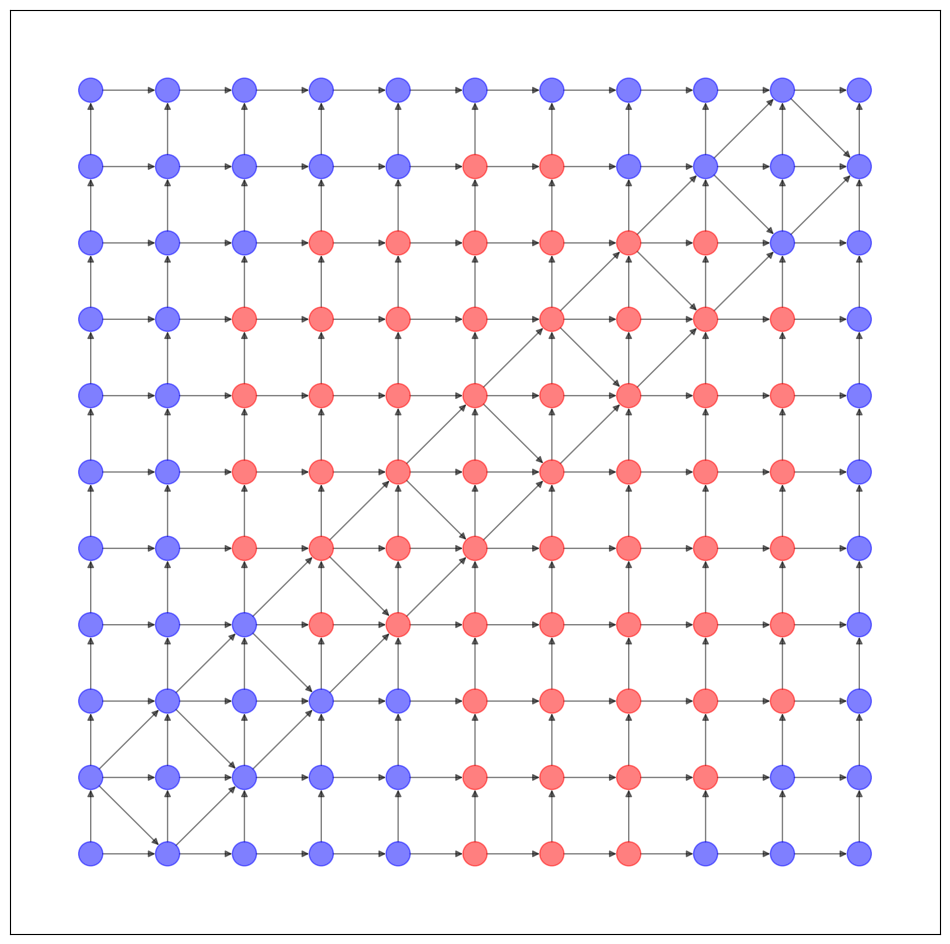

In [11]:
import networkx as nx
import matplotlib.pyplot as plt

dataset = GridDataset()
G = torch_geometric.utils.convert.to_networkx(dataset.data)
plt.figure(figsize=(12,12))
nx.draw_networkx(G, pos=dataset.layout(), with_labels=False, alpha=0.5, node_color=dataset.node_color())


In [12]:
import numpy as np
from scipy.spatial import distance
from torch_geometric.data import Data, InMemoryDataset

class ColonyDataset(InMemoryDataset):
    def __init__(self, transform = None):
        super().__init__('.', transform)

        f = lambda x: np.linalg.norm(x) - np.arctan2(x[0], x[1])
        embeddings = []
        ys = []

        for x in range(-10, 11, 5):
            for y in range(-10, 11, 5):
                embeddings.append([x, y])
                ys.append(f([x, y]))
                for theta in range(max(0, 15 - abs(x) - abs(y))):
                    x2 = x + np.sin(theta + np.random.rand()) * abs(17 - theta) * 0.1
                    y2 = y + np.cos(theta + np.random.rand()) * abs(17 - theta) * 0.1
                    embeddings.append([x2, y2])
                    ys.append(f([x2, y2]))
                
        embeddings = torch.tensor(embeddings, dtype=torch.float)
        y2 = []
        for y in ys:
            if y > np.array(ys).mean():
                y2.append(1)
            else:
                y2.append(0)
        ys = torch.tensor(y2, dtype=torch.float)

        dist_matrix = distance.cdist(embeddings, embeddings, metric='euclidean')
        edges = []
        edge_attr = []
        for i in range(len(dist_matrix)):
            for j in range(len(dist_matrix)):
                if i < j:
                    if dist_matrix[i][j] == 5 or dist_matrix[i][j] < 2:
                        edges.append([i, j])
                        edge_attr.append(abs(f(embeddings[i]) - f(embeddings[j])))

        edges = torch.tensor(edges).T
        edge_attr = torch.tensor(edge_attr)
        data = Data(x=embeddings, edge_index=edges, y=ys, edge_attr=edge_attr)
        self.data, self.slices = self.collate([data])
        self.data.num_nodes = len(embeddings)

    def layout(self):
        return {i:x.detach().numpy() for i, x in enumerate(self.data.x)}
    
    def node_color(self):
        c = {0:"red", 1:"blue"}
        return [c[int(x.detach().numpy())] for (i, x) in enumerate(self.data.y)]


/tmp/ipykernel_982507/4234755355.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  f = lambda x: np.linalg.norm(x) - np.arctan2(x[0], x[1])


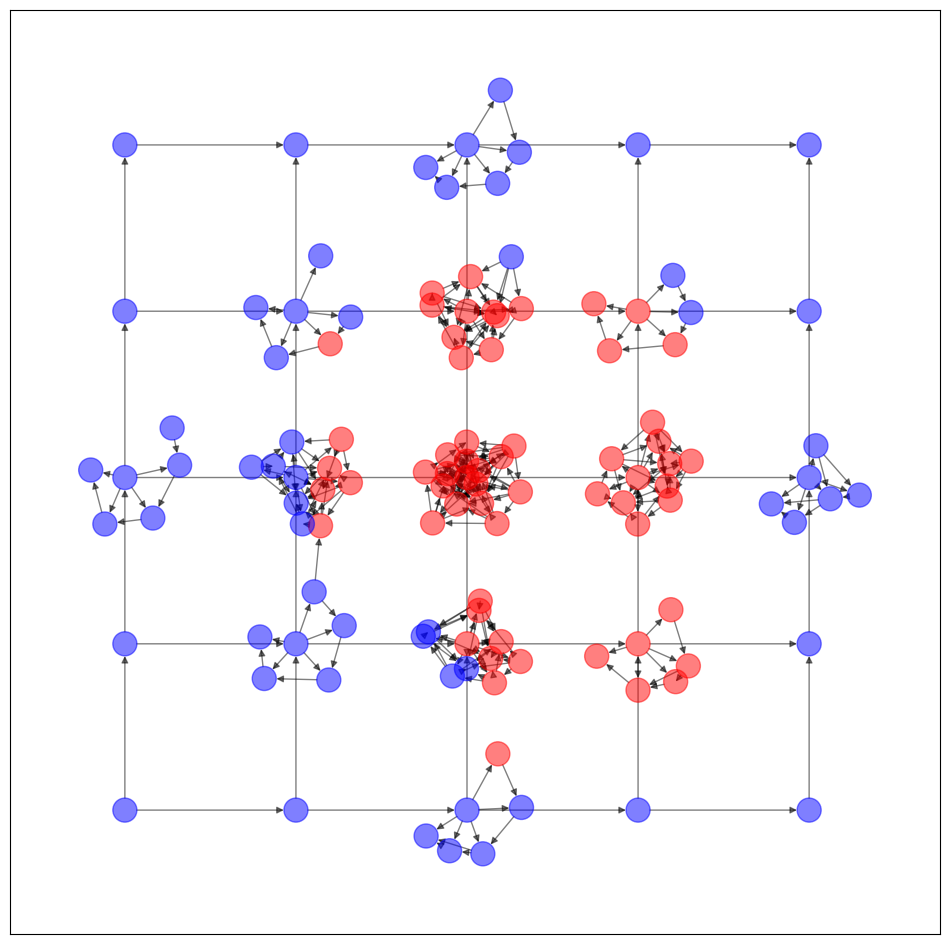

In [13]:
import networkx as nx
import matplotlib.pyplot as plt

dataset = ColonyDataset()
G = torch_geometric.utils.convert.to_networkx(dataset.data)
plt.figure(figsize=(12,12))
nx.draw_networkx(G, pos=dataset.layout(), with_labels=False, alpha=0.5, node_color=dataset.node_color())


In [21]:
# use_dataset = GridDataset
use_dataset = ColonyDataset


In [22]:
dataset = use_dataset()
data = dataset.data
data = torch_geometric.utils.train_test_split_edges(data)


/tmp/ipykernel_982507/4234755355.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  f = lambda x: np.linalg.norm(x) - np.arctan2(x[0], x[1])
/home/csl-stu/.pyenv/versions/2121057/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/home/csl-stu/.pyenv/versions/2121057/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


In [23]:
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = torch_geometric.nn.GCNConv(
            in_channels, 4 * out_channels, cached=True
            ) 
        self.conv1b = torch_geometric.nn.GCNConv(
            4 * out_channels, 16 * out_channels, cached=True
            ) 
        self.conv1c = torch_geometric.nn.GCNConv(
            16 * out_channels, 32 * out_channels, cached=True
            ) 
        self.conv1d = torch_geometric.nn.GCNConv(
            32 * out_channels, 16 * out_channels, cached=True
            ) 
        self.conv1e = torch_geometric.nn.GCNConv(
            16 * out_channels, 4 * out_channels, cached=True
            ) 
        self.conv2 = torch_geometric.nn.GCNConv(
            4 * out_channels, out_channels, cached=True
            ) 

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv1b(x, edge_index).relu()
        x = self.conv1c(x, edge_index).relu()
        x = self.conv1d(x, edge_index).relu()
        x = self.conv1e(x, edge_index).relu()
        return self.conv2(x, edge_index)


In [24]:
def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(x, train_pos_edge_index)
    loss = model.recon_loss(z, train_pos_edge_index)
    loss.backward()
    optimizer.step()
    return float(loss)

def test(pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, train_pos_edge_index)
    return model.test(z, pos_edge_index, neg_edge_index)


In [25]:
epochs = 500
out_channels = 16

num_features = dataset.num_features
model = torch_geometric.nn.GAE(GCNEncoder(num_features, out_channels))
model = model.to(device)

x = data.x.to(device)
train_pos_edge_index = data.train_pos_edge_index.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


In [26]:
import copy

loss_hist = []
auc_hist = []
ap_hist = []
best_score = None
for epoch in range(1, epochs + 1):
    loss = train()
    auc, ap = test(data.test_pos_edge_index, data.test_neg_edge_index)
    loss_hist.append(loss)
    auc_hist.append(auc)
    ap_hist.append(ap)
    if best_score is None or best_score < ap:
        best_score = ap
        best_model = copy.deepcopy(model)
        print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}, Loss: {}'.format(epoch, auc, ap, loss))


Epoch: 001, AUC: 0.4807, AP: 0.5003, Loss: 1.410189151763916
Epoch: 002, AUC: 0.4568, AP: 0.5536, Loss: 26.665599822998047
Epoch: 003, AUC: 0.4961, AP: 0.5977, Loss: 3.266024112701416
Epoch: 012, AUC: 0.7338, AP: 0.6313, Loss: 1.3574955463409424
Epoch: 013, AUC: 0.7446, AP: 0.6403, Loss: 1.352693796157837
Epoch: 014, AUC: 0.7492, AP: 0.6486, Loss: 1.3404854536056519
Epoch: 015, AUC: 0.7608, AP: 0.6819, Loss: 1.3102130889892578
Epoch: 022, AUC: 0.7577, AP: 0.6852, Loss: 1.212398886680603
Epoch: 023, AUC: 0.7809, AP: 0.7348, Loss: 1.1865400075912476
Epoch: 026, AUC: 0.7840, AP: 0.7454, Loss: 1.0941877365112305
Epoch: 027, AUC: 0.8264, AP: 0.8320, Loss: 1.1110565662384033
Epoch: 054, AUC: 0.8110, AP: 0.8329, Loss: 1.0448700189590454
Epoch: 055, AUC: 0.8110, AP: 0.8341, Loss: 1.062413215637207
Epoch: 064, AUC: 0.8202, AP: 0.8395, Loss: 1.044218897819519
Epoch: 073, AUC: 0.8326, AP: 0.8459, Loss: 1.021074652671814
Epoch: 083, AUC: 0.8380, AP: 0.8463, Loss: 0.995715856552124
Epoch: 089, AUC:

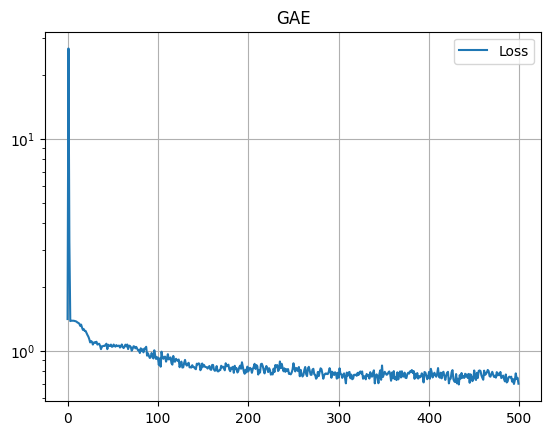

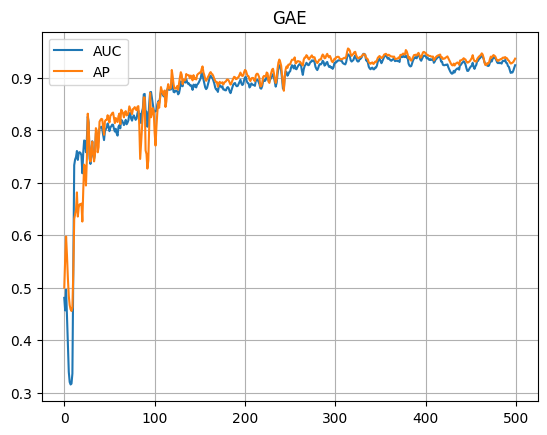

In [27]:
import matplotlib.pyplot as plt

plt.title("GAE")
plt.plot(loss_hist, label="Loss")
plt.grid()
plt.legend()
plt.yscale('log')
plt.show()
plt.title("GAE")
plt.plot(auc_hist, label="AUC")
plt.plot(ap_hist, label="AP")
plt.grid()
plt.legend()
plt.show()


In [28]:
z = best_model.encode(x, train_pos_edge_index)
prob_adj = z @ z.T
prob_adj = prob_adj - torch.diagonal(prob_adj)
prob_adj


tensor([[ 0.0000, -0.1308, -1.7368,  ..., -1.8967, -1.0718, -1.1682],
        [ 0.1013,  0.0000, -1.4726,  ..., -1.9318, -1.0076, -1.0868],
        [ 0.7515,  0.7837,  0.0000,  ..., -2.1094, -0.8948, -0.9152],
        ...,
        [-1.8504, -2.1176, -4.5515,  ...,  0.0000, -0.4820, -0.9851],
        [-1.8228, -1.9906, -4.1341,  ..., -1.2792,  0.0000, -0.1257],
        [-1.7572, -1.9079, -3.9925,  ..., -1.6204,  0.0363,  0.0000]],
       grad_fn=<SubBackward0>)

In [29]:
prob_adj_values = prob_adj.detach().cpu().numpy().flatten()
prob_adj_values.sort()
dataset = use_dataset()
threshold = prob_adj_values[-len(dataset.data.edge_attr)]
dataset.data.edge_index = (prob_adj >= threshold).nonzero(as_tuple=False).t()


/tmp/ipykernel_982507/4234755355.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  f = lambda x: np.linalg.norm(x) - np.arctan2(x[0], x[1])
/home/csl-stu/.pyenv/versions/2121057/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


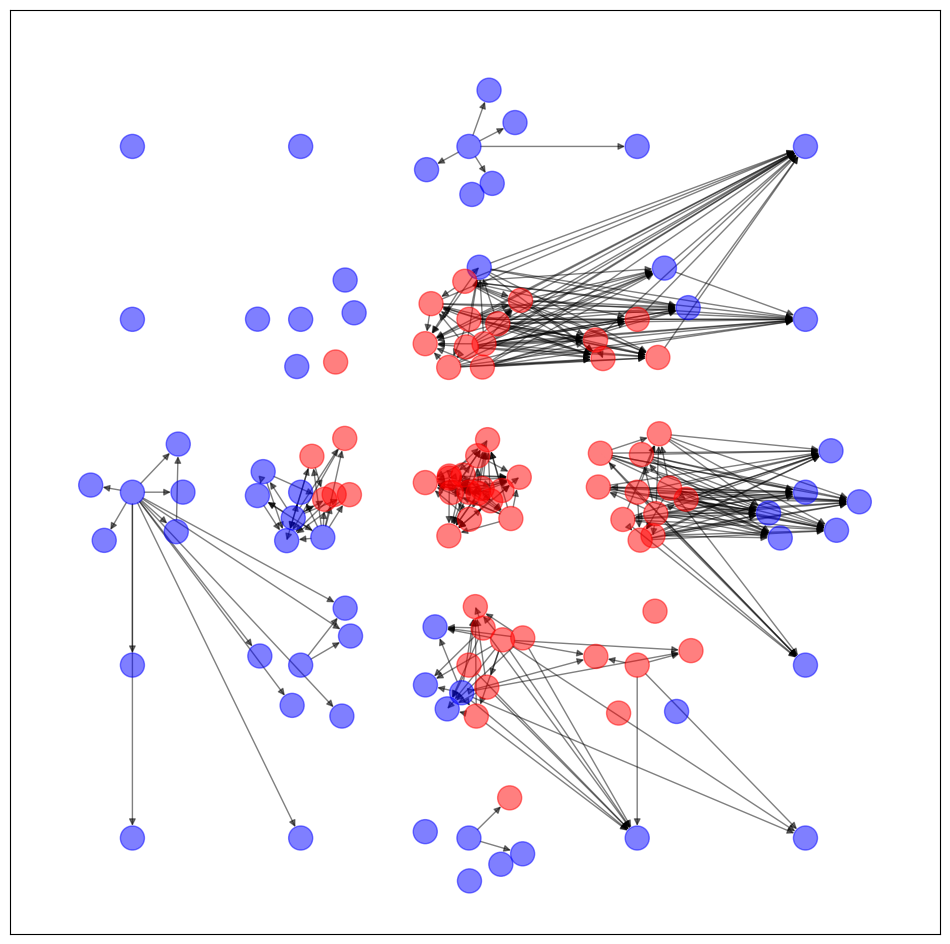

In [30]:
import networkx as nx
import matplotlib.pyplot as plt

G = torch_geometric.utils.convert.to_networkx(dataset.data)
plt.figure(figsize=(12,12))
nx.draw_networkx(G, pos=dataset.layout(), with_labels=False, alpha=0.5, node_color=dataset.node_color())


# Variable Auto Encoder

In [31]:
class VariationalGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(VariationalGCNEncoder, self).__init__()
        self.conv1 = torch_geometric.nn.GCNConv(
            in_channels, 4 * out_channels, cached=True
            ) 
        self.conv1b = torch_geometric.nn.GCNConv(
            4 * out_channels, 16 * out_channels, cached=True
            ) 
        self.conv1c = torch_geometric.nn.GCNConv(
            16 * out_channels, 32 * out_channels, cached=True
            ) 
        self.conv1d = torch_geometric.nn.GCNConv(
            32 * out_channels, 16 * out_channels, cached=True
            ) 
        self.conv1e = torch_geometric.nn.GCNConv(
            16 * out_channels, 4 * out_channels, cached=True
            ) 
        self.conv_mu = torch_geometric.nn.GCNConv(
            4 * out_channels, out_channels, cached=True
            )
        self.conv_logstd = torch_geometric.nn.GCNConv(
            4 * out_channels, out_channels, cached=True
            )

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv1b(x, edge_index).relu()
        x = self.conv1c(x, edge_index).relu()
        x = self.conv1d(x, edge_index).relu()
        x = self.conv1e(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)


In [32]:
def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(x, train_pos_edge_index)
    loss = model.recon_loss(z, train_pos_edge_index)
    loss = loss + (1 / data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    return float(loss)

def test(pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, train_pos_edge_index)
    return model.test(z, pos_edge_index, neg_edge_index)


In [33]:
epochs = 500
out_channels = 16

num_features = dataset.num_features
model = torch_geometric.nn.VGAE(
    VariationalGCNEncoder(num_features, out_channels)
    )
model = model.to(device)

x = data.x.to(device)
train_pos_edge_index = data.train_pos_edge_index.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


In [34]:
import copy

loss_hist = []
auc_hist = []
ap_hist = []
best_score = None
for epoch in range(1, epochs + 1):
    loss = train()
    auc, ap = test(data.test_pos_edge_index, data.test_neg_edge_index)
    loss_hist.append(loss)
    auc_hist.append(auc)
    ap_hist.append(ap)
    if best_score is None or best_score < ap:
        best_score = ap
        best_model = copy.deepcopy(model)
        print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}, Loss: {}'.format(epoch, auc, ap, loss))


Epoch: 001, AUC: 0.4799, AP: 0.4997, Loss: 3.140631914138794
Epoch: 002, AUC: 0.4745, AP: 0.5296, Loss: 33.110801696777344
Epoch: 003, AUC: 0.4468, AP: 0.5707, Loss: 13.157015800476074
Epoch: 004, AUC: 0.5710, AP: 0.6411, Loss: 4.648372650146484
Epoch: 006, AUC: 0.5486, AP: 0.6438, Loss: 2.838573455810547
Epoch: 007, AUC: 0.5895, AP: 0.6597, Loss: 2.6070806980133057
Epoch: 011, AUC: 0.5941, AP: 0.6619, Loss: 1.8033820390701294
Epoch: 012, AUC: 0.6343, AP: 0.6770, Loss: 1.7081975936889648
Epoch: 013, AUC: 0.7315, AP: 0.7216, Loss: 1.6137503385543823
Epoch: 014, AUC: 0.7747, AP: 0.7326, Loss: 1.5781806707382202
Epoch: 015, AUC: 0.7770, AP: 0.7351, Loss: 1.5212420225143433
Epoch: 016, AUC: 0.7801, AP: 0.7469, Loss: 1.5163952112197876
Epoch: 017, AUC: 0.7909, AP: 0.7580, Loss: 1.5211005210876465
Epoch: 018, AUC: 0.8002, AP: 0.7695, Loss: 1.5011929273605347
Epoch: 019, AUC: 0.8241, AP: 0.7868, Loss: 1.4430962800979614
Epoch: 020, AUC: 0.8356, AP: 0.8028, Loss: 1.4106571674346924
Epoch: 021,

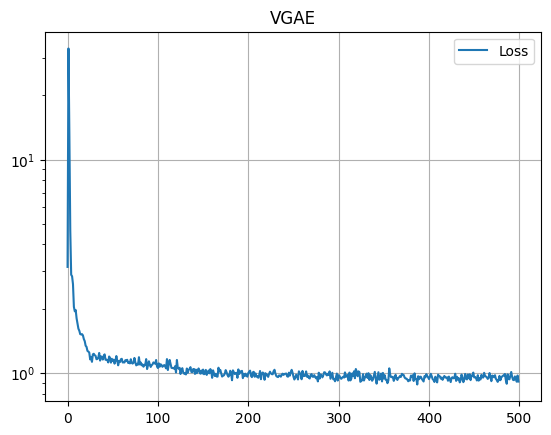

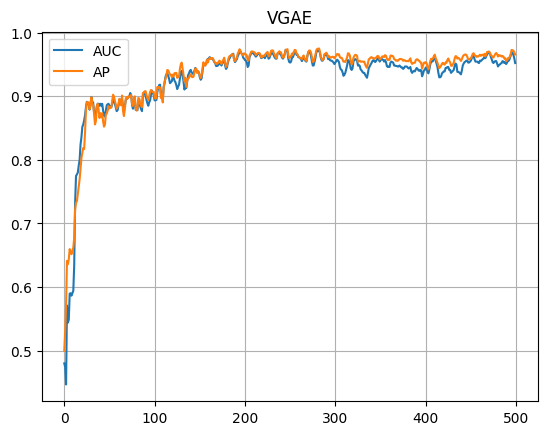

In [35]:
import matplotlib.pyplot as plt

plt.title("VGAE")
plt.plot(loss_hist, label="Loss")
plt.grid()
plt.legend()
plt.yscale('log')
plt.show()
plt.title("VGAE")
plt.plot(auc_hist, label="AUC")
plt.plot(ap_hist, label="AP")
plt.grid()
plt.legend()
plt.show()


In [36]:
z = best_model.encode(x, train_pos_edge_index)
prob_adj = z @ z.T
prob_adj = prob_adj - torch.diagonal(prob_adj)
prob_adj


tensor([[ 0.0000, -0.1292, -2.4051,  ..., -1.5336, -2.2320, -1.7559],
        [ 0.0121,  0.0000, -1.8734,  ..., -1.5077, -2.1835, -1.6951],
        [-0.4536, -0.0631,  0.0000,  ..., -1.2469, -1.7719, -1.2629],
        ...,
        [-1.3024, -1.4179, -2.9672,  ...,  0.0000, -0.3193, -0.0889],
        [-1.4267, -1.5195, -2.9181,  ...,  0.2549,  0.0000,  0.1923],
        [-1.3677, -1.4483, -2.8262,  ...,  0.0681, -0.2248,  0.0000]],
       grad_fn=<SubBackward0>)

In [37]:
prob_adj_values = prob_adj.detach().cpu().numpy().flatten()
prob_adj_values.sort()
dataset = use_dataset()
threshold = prob_adj_values[-len(dataset.data.edge_attr)]
dataset.data.edge_index = (prob_adj >= threshold).nonzero(as_tuple=False).t()


/tmp/ipykernel_982507/4234755355.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  f = lambda x: np.linalg.norm(x) - np.arctan2(x[0], x[1])
/home/csl-stu/.pyenv/versions/2121057/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


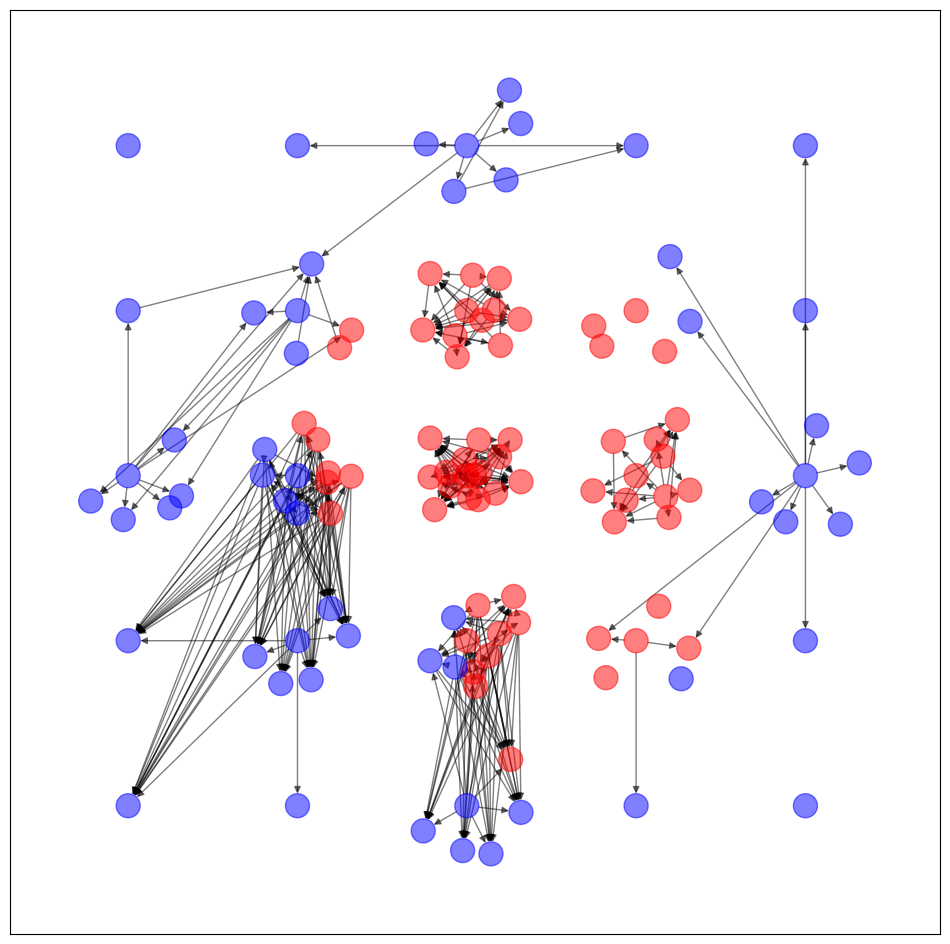

In [38]:
import networkx as nx
import matplotlib.pyplot as plt

G = torch_geometric.utils.convert.to_networkx(dataset.data)
plt.figure(figsize=(12,12))
nx.draw_networkx(G, pos=dataset.layout(), with_labels=False, alpha=0.5, node_color=dataset.node_color())
